<a href="https://colab.research.google.com/github/kotireddys/masters_thesis/blob/main/Thesis_1_Dataprep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rasterio
import rasterio as rio
from rasterio.windows import from_bounds
from rasterio.warp import transform_bounds
import numpy as np
from pathlib import Path

aerial_path = "/content/drive/MyDrive/Thesis/Simulate US D1/32AN1_18/634c391a39ec3b000787e34c.tif"                       # GeoTIFF (RGB or pansharpened imagery)
lidar_path  = "/content/drive/MyDrive/Thesis/Simulate US D1/32AN1_18/Latest_32AN1_18_raster.tif"                    # GeoTIFF (DEM / LiDAR raster)
out_path    = "lidar_cropped_to_aerial_extent.tif"

with rio.open(aerial_path) as a_ds, rio.open(lidar_path) as l_ds:
    # 1) Get aerial image bounds (in aerial CRS)
    a_bounds = a_ds.bounds

    # 2) If CRSs differ, transform the aerial bounds into the LiDAR CRS
    if a_ds.crs != l_ds.crs:
        # densify_pts improves accuracy when warping the rectangle between CRSs
        a_bounds_in_lidar = transform_bounds(a_ds.crs, l_ds.crs, *a_bounds, densify_pts=21)
    else:
        a_bounds_in_lidar = a_bounds

    # 3) Build a LiDAR window from those bounds
    win = from_bounds(*a_bounds_in_lidar, transform=l_ds.transform)

    # (Optional but recommended) Round to pixel edges to avoid half-pixel offsets
    win = win.round_offsets().round_lengths()

    # 4) Read the LiDAR data inside that window (boundless lets us pad if the extents don’t fully overlap)
    fill = l_ds.nodata if l_ds.nodata is not None else 0
    data = l_ds.read(window=win, boundless=True, fill_value=fill)

    # 5) Derive the output transform for the cropped window
    out_transform = l_ds.window_transform(win)

    # 6) Prepare metadata and write the cropped LiDAR
    meta = l_ds.meta.copy()
    meta.update({
        "height": data.shape[1],
        "width":  data.shape[2],
        "transform": out_transform,
        "nodata": fill
    })

    # Ensure directory exists
    Path(out_path).parent.mkdir(parents=True, exist_ok=True)

    with rio.open(out_path, "w", **meta) as dst:
        dst.write(data)

print(f"✅ Wrote cropped LiDAR to: {out_path}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 68.7 MB/s eta 0:00:00
✅ Wrote cropped LiDAR to: lidar_cropped_to_aerial_extent.tif


Verifying if they were aligned


In [ ]:
import rasterio as rio
from rasterio.warp import transform_bounds
from rasterio.transform import array_bounds

aerial = "/content/drive/MyDrive/Thesis/Simulate US D1/32AN1_18/634c391a39ec3b000787e34c.tif"
lidar_cropped = "/content/lidar_cropped_to_aerial_extent.tif"  # or your path

with rio.open(aerial) as a_ds, rio.open(lidar_cropped) as l_ds:
    # 1) Compare CRS
    print("CRS equal?", a_ds.crs == l_ds.crs)

    # 2) Compute aerial bounds in LiDAR CRS
    a_bounds = a_ds.bounds
    if a_ds.crs != l_ds.crs:
        a_bounds_in_lidar = transform_bounds(a_ds.crs, l_ds.crs, *a_bounds, densify_pts=21)
    else:
        a_bounds_in_lidar = a_bounds

    # 3) Bounds of the cropped LiDAR (from its own grid)
    l_bounds = array_bounds(l_ds.height, l_ds.width, l_ds.transform)

    print("Aerial bounds in LiDAR CRS:", a_bounds_in_lidar)
    print("Cropped LiDAR bounds     :", l_bounds)

    # 4) Check how close they are (expect ≤ ~1 pixel diff due to grid snapping)
    px_w = abs(l_ds.transform.a)
    px_h = abs(l_ds.transform.e)
    tol_x = px_w
    tol_y = px_h

    def within_tol(b1, b2, tx, ty):
        (minx1, miny1, maxx1, maxy1) = b1
        (minx2, miny2, maxx2, maxy2) = b2
        return (abs(minx1-minx2) <= tx and abs(maxx1-maxx2) <= tx and
                abs(miny1-miny2) <= ty and abs(maxy1-maxy2) <= ty)

    print("Extents match (≤1 px tolerance)?",
          within_tol(a_bounds_in_lidar, l_bounds, tol_x, tol_y))

    # 5) NoData pad check (if boundless=True was used)
    nodata = l_ds.nodata
    if nodata is not None:
        arr = l_ds.read(1, masked=True)
        nodata_frac = arr.mask.mean()
        print(f"NoData fraction in cropped tile: {nodata_frac:.4f}")


CRS equal? False
Aerial bounds in LiDAR CRS: (142192.30924117274, 470053.6536765789, 142579.93385552452, 470624.7629962307)
Cropped LiDAR bounds     : (142191.977, 470053.81, 142579.977, 470624.81)
Extents match (≤1 px tolerance)? True
NoData fraction in cropped tile: 0.0085


print pixel size + bound deltas

In [ ]:
import rasterio as rio
from rasterio.warp import transform_bounds

aerial = "/content/drive/MyDrive/Thesis/Simulate US D1/32AN1_18/634c391a39ec3b000787e34c.tif"
lidar  = "/content/lidar_cropped_to_aerial_extent.tif"

with rio.open(aerial) as a_ds, rio.open(lidar) as l_ds:
    a_b = a_ds.bounds
    a_b_in_l = transform_bounds(a_ds.crs, l_ds.crs, *a_b, densify_pts=21)
    l_b = (l_ds.transform.c,
           l_ds.transform.f + l_ds.transform.e * l_ds.height,
           l_ds.transform.c + l_ds.transform.a * l_ds.width,
           l_ds.transform.f)

    px_w, px_h = abs(l_ds.transform.a), abs(l_ds.transform.e)
    deltas = [abs(a_b_in_l[i]-l_b[i]) for i in range(4)]
    print(f"LiDAR pixel size: {px_w:.3f} x {px_h:.3f} (units of CRS)")
    print("Bound deltas (minx, miny, maxx, maxy):", [round(d, 3) for d in deltas])


LiDAR pixel size: 1.000 x 1.000 (units of CRS)
Bound deltas (minx, miny, maxx, maxy): [0.332, 0.156, 0.043, 0.047]


pixel-for-pixel overlay with the aerial (same CRS, transform, width/height), just reproject the cropped LiDAR to the aerial grid.

In [ ]:
# Minimal: reproject cropped LiDAR to match aerial's grid exactly
# (same CRS, transform, width, height)

import numpy as np
import rasterio as rio
from rasterio.warp import reproject, Resampling

AERIAL = "/content/drive/MyDrive/Thesis/Simulate US D1/32AN1_18/634c391a39ec3b000787e34c.tif"
LIDAR_CROP = "/content/lidar_cropped_to_aerial_extent.tif"   # your current cropped DEM
LIDAR_ALIGNED = "lidar_cropped_aligned_to_aerial.tif"

with rio.open(AERIAL) as a_ds, rio.open(LIDAR_CROP) as l_ds:
    # Prepare output metadata to match the aerial georeferencing & shape
    nodata = l_ds.nodata if l_ds.nodata is not None else 0
    out_meta = l_ds.meta.copy()
    out_meta.update({
        "crs": a_ds.crs,
        "transform": a_ds.transform,
        "width": a_ds.width,
        "height": a_ds.height,
        "nodata": nodata,
        "dtype": l_ds.dtypes[0]
    })

    # Allocate destination array
    out = np.full((l_ds.count, a_ds.height, a_ds.width), nodata, dtype=l_ds.dtypes[0])

    # DEMs: bilinear is typical; use 'nearest' if you must preserve categorical values
    for b in range(1, l_ds.count + 1):
        reproject(
            source=rio.band(l_ds, b),
            destination=out[b-1],
            src_transform=l_ds.transform, src_crs=l_ds.crs,
            dst_transform=a_ds.transform, dst_crs=a_ds.crs,
            resampling=Resampling.bilinear,
            dst_nodata=nodata
        )

    with rio.open(LIDAR_ALIGNED, "w", **out_meta) as dst:
        dst.write(out)

# --- Verify exact grid match ---
with rio.open(AERIAL) as a_ds, rio.open(LIDAR_ALIGNED) as l2:
    print("CRS match:", a_ds.crs == l2.crs)
    print("Transform match:", a_ds.transform == l2.transform)
    print("Shape match:", (a_ds.height, a_ds.width) == (l2.height, l2.width))
    print("Exact pixel-for-pixel overlay:",
          a_ds.crs == l2.crs and a_ds.transform == l2.transform and
          a_ds.width == l2.width and a_ds.height == l2.height)


CRS match: True
Transform match: True
Shape match: True
Exact pixel-for-pixel overlay: True


Visual verification

ℹ️ Grids differ — auto-warping DEM to aerial grid for display...


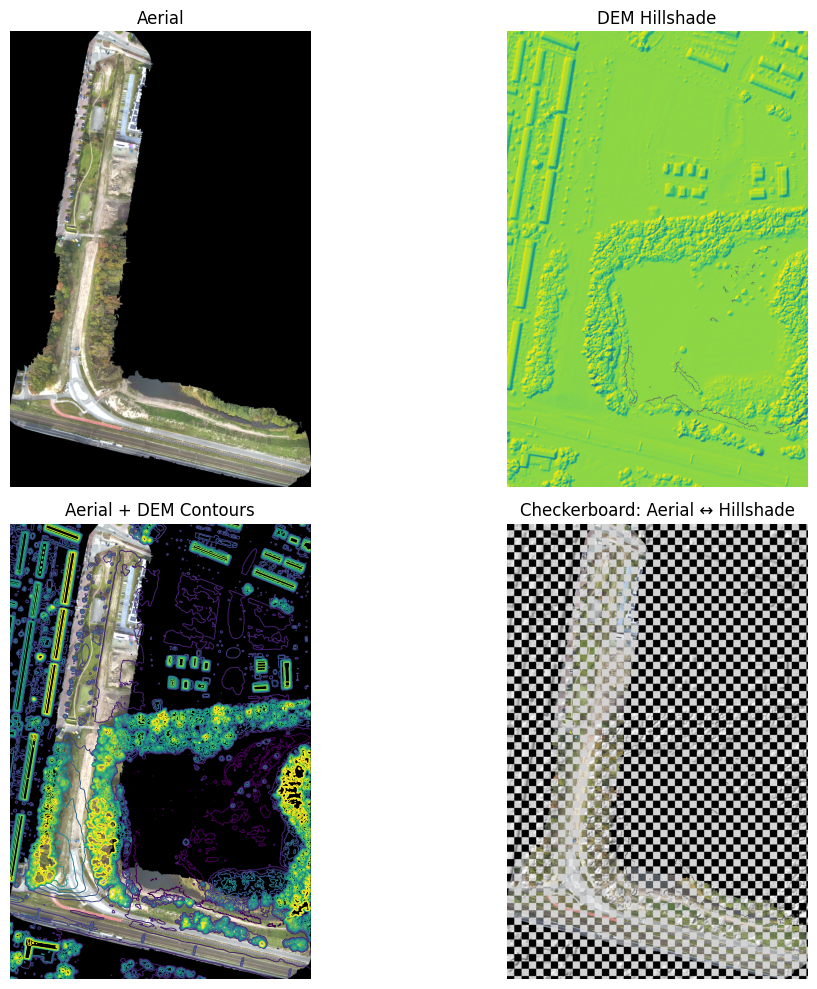

In [ ]:
# Visual overlay checks for pixel-for-pixel alignment
# Files: update paths if needed
AERIAL = "/content/drive/MyDrive/Thesis/Simulate US D1/32AN1_18/634c391a39ec3b000787e34c.tif"
DEM    = "/content/lidar_cropped_to_aerial_extent.tif"  # the reprojected DEM that matches aerial grid

import numpy as np
import rasterio as rio
from rasterio.enums import Resampling
from rasterio.vrt import WarpedVRT
import matplotlib.pyplot as plt

def read_for_display(ds, max_wh=2048, bands=(1,2,3)):
    """Read dataset with optional downscale so max(width,height) <= max_wh."""
    H, W = ds.height, ds.width
    scale = max(1, int(np.ceil(max(H, W) / max_wh)))
    out_h, out_w = max(1, H // scale), max(1, W // scale)

    if ds.count >= 3 and bands:
        arr = ds.read(indexes=list(bands), out_shape=(len(bands), out_h, out_w),
                      resampling=Resampling.bilinear).astype(np.float32)
        # Robust per-band normalization 1..99%
        for b in range(arr.shape[0]):
            band = arr[b]
            valid = np.isfinite(band)
            if valid.any():
                vmin, vmax = np.percentile(band[valid], [1, 99])
                arr[b] = np.clip((band - vmin) / max(vmax - vmin, 1e-6), 0, 1)
        rgb = np.moveaxis(arr, 0, -1)
        return rgb, scale
    else:
        # Single band
        arr = ds.read(1, out_shape=(out_h, out_w),
                      resampling=Resampling.bilinear).astype(np.float32)
        return arr, scale

def hillshade(elev, azimuth=315, altitude=45, cellsize=1.0):
    """Simple Horn hillshade from elevation; returns 0..1 image."""
    # gradients (dz/dx, dz/dy)
    x, y = np.gradient(elev, cellsize, cellsize)
    slope = np.pi/2 - np.arctan(np.hypot(x, y))
    aspect = np.arctan2(-x, y)
    az = np.deg2rad(azimuth); alt = np.deg2rad(altitude)
    hs = (np.sin(alt) * np.sin(slope) +
          np.cos(alt) * np.cos(slope) * np.cos(az - aspect))
    hs = (hs - hs.min()) / max(hs.max() - hs.min(), 1e-9)
    return hs.astype(np.float32)

def almost_equal_transform(t1, t2, atol=1e-9):
    # Compare Affine components with tolerance
    return (abs(t1.a - t2.a) <= atol and
            abs(t1.b - t2.b) <= atol and
            abs(t1.c - t2.c) <= atol and
            abs(t1.d - t2.d) <= atol and
            abs(t1.e - t2.e) <= atol and
            abs(t1.f - t2.f) <= atol)

with rio.open(AERIAL) as a_ds, rio.open(DEM) as d_ds:
    same_grid = (a_ds.crs == d_ds.crs and
                 a_ds.width == d_ds.width and a_ds.height == d_ds.height and
                 almost_equal_transform(a_ds.transform, d_ds.transform, atol=1e-12))
    if not same_grid:
        print("ℹ️ Grids differ — auto-warping DEM to aerial grid for display...")
        vrt_opts = dict(
            crs=a_ds.crs,
            transform=a_ds.transform,
            width=a_ds.width,
            height=a_ds.height,
            resampling=Resampling.bilinear
        )
        dem_view = WarpedVRT(d_ds, **vrt_opts)
        close_after = True
    else:
        print("✅ Grids match — reading both directly.")
        dem_view = d_ds
        close_after = False

    # Read aerial & DEM (downsampled for plotting)
    aerial_disp, _ = read_for_display(a_ds, max_wh=2048, bands=(1,2,3) if a_ds.count>=3 else None)
    dem_disp,    _ = read_for_display(dem_view, max_wh=2048, bands=None)

    # Ensure shapes match for overlay
    if aerial_disp.ndim == 2:
        aerial_rgb = np.repeat(aerial_disp[..., None], 3, axis=-1)
    else:
        aerial_rgb = aerial_disp
    if dem_disp.ndim == 3:  # rare
        dem_disp = dem_disp[0]

    # Normalize DEM for contours
    valid = np.isfinite(dem_disp)
    if valid.any():
        vmin, vmax = np.percentile(dem_disp[valid], [2, 98])
    else:
        vmin, vmax = 0, 1
    dem_norm = np.clip((dem_disp - vmin) / max(vmax - vmin, 1e-6), 0, 1)

    # Hillshade
    hs = hillshade(dem_disp, azimuth=315, altitude=45, cellsize=1.0)
    hs_rgb = np.repeat(hs[..., None], 3, axis=-1)

    # Checkerboard blend
    H, W = hs.shape
    tile = 32
    rr, cc = np.indices((H, W))
    checker = ((rr // tile) + (cc // tile)) % 2 == 0
    aerial_dim = np.clip(aerial_rgb * 0.9, 0, 1)
    checkerboard = np.where(checker[..., None], aerial_dim, hs_rgb)

    # Plot
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    axs = axs.ravel()

    axs[0].imshow(aerial_rgb, origin='upper')
    axs[0].set_title("Aerial")
    axs[0].axis('off')

    axs[1].imshow(hs, origin='upper')
    axs[1].set_title("DEM Hillshade")
    axs[1].axis('off')

    axs[2].imshow(aerial_rgb, origin='upper')
    cs = axs[2].contour(dem_disp, levels=np.linspace(vmin, vmax, 12), linewidths=0.7)
    axs[2].set_title("Aerial + DEM Contours")
    axs[2].axis('off')

    axs[3].imshow(checkerboard, origin='upper')
    axs[3].set_title("Checkerboard: Aerial ↔ Hillshade")
    axs[3].axis('off')

    plt.tight_layout()
    plt.show()

    if close_after:
        dem_view.close()


✅ Wrote
  • Full-size masked DEM: lidar_masked_to_aerial_footprint.tif
  • Cropped-to-footprint DEM: lidar_masked_cropped_to_footprint.tif


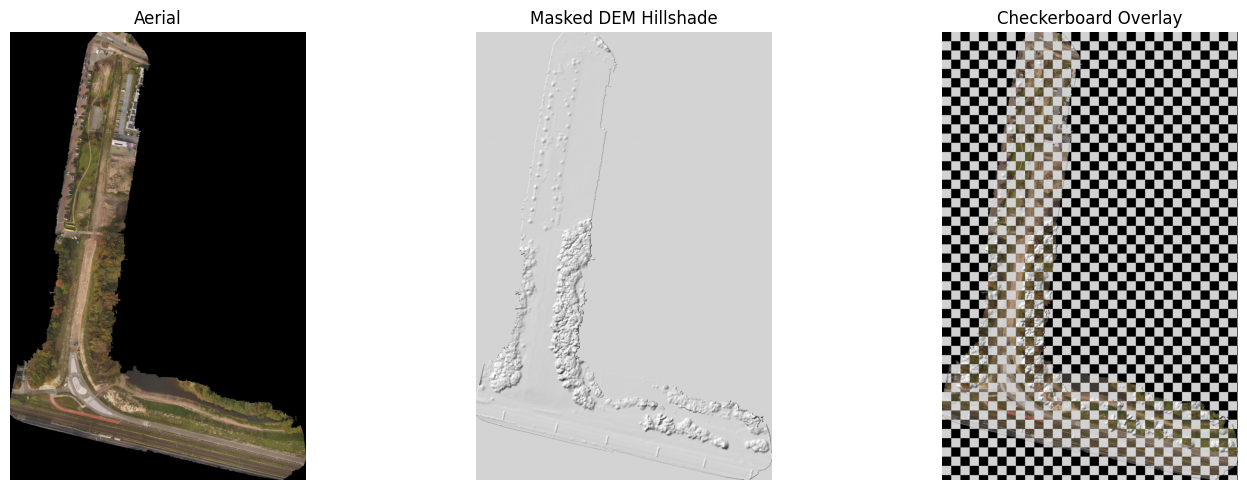

In [ ]:
# Auto-warp DEM to aerial grid -> mask to aerial footprint -> tight crop -> visualize

import numpy as np
import rasterio as rio
from rasterio.enums import Resampling
from rasterio.windows import Window
from rasterio.vrt import WarpedVRT
import matplotlib.pyplot as plt

# scikit-image for connected-component labeling (fallback)
try:
    from skimage.measure import label
except Exception:
    import sys, subprocess
    subprocess.run([sys.executable, "-m", "pip", "install", "-q", "scikit-image"], check=False)
    from skimage.measure import label

AERIAL = "/content/drive/MyDrive/Thesis/Simulate US D1/32AN1_18/634c391a39ec3b000787e34c.tif"
DEM_IN = "/content/lidar_cropped_to_aerial_extent.tif"  # any DEM (aligned or not)
DEM_MASKED  = "lidar_masked_to_aerial_footprint.tif"
DEM_CROPPED = "lidar_masked_cropped_to_footprint.tif"

BLACK_SUM_THRESHOLD = 3  # fallback: treat border-connected pure black as background

def hillshade(elev, azimuth=315, altitude=45, cellsize=1.0):
    gx, gy = np.gradient(elev, cellsize, cellsize)
    slope  = np.pi/2 - np.arctan(np.hypot(gx, gy))
    aspect = np.arctan2(-gx, gy)
    az = np.deg2rad(azimuth); alt = np.deg2rad(altitude)
    hs = (np.sin(alt)*np.sin(slope) + np.cos(alt)*np.cos(slope)*np.cos(az - aspect))
    hs = (hs - hs.min()) / max(hs.max() - hs.min(), 1e-9)
    return hs.astype(np.float32)

with rio.open(AERIAL) as a_ds, rio.open(DEM_IN) as d_src:
    H, W = a_ds.height, a_ds.width

    # --- A) Build aerial footprint (True = valid pixels) ---
    # Preferred: alpha/NoData via dataset_mask
    ds_mask = a_ds.dataset_mask()  # 0=nodata, 255=valid
    valid = ds_mask != 0

    # Fallback: detect only border-connected black background
    if valid.mean() > 0.999:
        if a_ds.count >= 3:
            scale = max(1, int(np.ceil(max(H, W)/2048)))
            rgb = a_ds.read([1,2,3], out_shape=(3, H//scale, W//scale),
                            resampling=Resampling.nearest).astype(np.uint16)
            black_coarse = (rgb.sum(axis=0) <= BLACK_SUM_THRESHOLD)
            lbl = label(black_coarse, connectivity=1)
            edge_labels = set(np.concatenate([lbl[0,:], lbl[-1,:], lbl[:,0], lbl[:,-1]]))
            edge_labels.discard(0)
            bg_coarse = np.isin(lbl, list(edge_labels))
            bg_full = np.repeat(np.repeat(bg_coarse, scale, axis=0), scale, axis=1)[:H, :W]
            valid = ~bg_full
        else:
            b1 = a_ds.read(1)
            if a_ds.nodata is not None:
                valid = (b1 != a_ds.nodata)
            else:
                valid = (b1 > 0)

    # --- B) Warped VRT: DEM in aerial CRS/transform/shape (in-memory) ---
    vrt_opts = dict(
        crs=a_ds.crs,
        transform=a_ds.transform,
        width=W,
        height=H,
        resampling=Resampling.bilinear
    )
    with WarpedVRT(d_src, **vrt_opts) as d_vrt:
        dem = d_vrt.read(1).astype(np.float32)

    nodata = d_src.nodata if d_src.nodata is not None else -9999.0

    # --- C) Apply footprint to DEM ---
    dem_masked = dem.copy()
    dem_masked[~valid] = nodata

    out_meta = d_src.meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "height": H,
        "width":  W,
        "crs": a_ds.crs,
        "transform": a_ds.transform,
        "count": 1,
        "dtype": "float32",
        "nodata": nodata,
        "compress": "DEFLATE",
        "predictor": 2
    })
    with rio.open(DEM_MASKED, "w", **out_meta) as dst:
        dst.write(dem_masked, 1)

    # --- D) Tight crop to the footprint's bounding box ---
    if valid.any():
        rows, cols = np.where(valid)
        r0, r1 = rows.min(), rows.max()+1
        c0, c1 = cols.min(), cols.max()+1
        win = Window.from_slices((r0, r1), (c0, c1))
        dem_crop = dem_masked[r0:r1, c0:c1]

        meta_crop = out_meta.copy()
        meta_crop.update({
            "height": dem_crop.shape[0],
            "width":  dem_crop.shape[1],
            "transform": a_ds.window_transform(win)  # correct order
        })
        with rio.open(DEM_CROPPED, "w", **meta_crop) as dst:
            dst.write(dem_crop, 1)
    else:
        print("⚠️ No valid pixels detected in aerial footprint — skipping crop.")

print("✅ Wrote")
print("  • Full-size masked DEM:", DEM_MASKED)
print("  • Cropped-to-footprint DEM:", DEM_CROPPED)

# --- E) Visual check (downsampled) ---
with rio.open(AERIAL) as a_ds, rio.open(DEM_MASKED) as d_ms:
    max_wh = 1600
    s = max(1, int(np.ceil(max(a_ds.height, a_ds.width)/max_wh)))

    if a_ds.count >= 3:
        rgb = a_ds.read([1,2,3], out_shape=(3, a_ds.height//s, a_ds.width//s),
                        resampling=Resampling.bilinear).astype(np.float32)
        rgb = np.moveaxis(rgb, 0, -1)
        rgb -= rgb.min((0,1)); rgb /= max(rgb.max(), 1e-6)
    else:
        b = a_ds.read(1, out_shape=(a_ds.height//s, a_ds.width//s),
                      resampling=Resampling.bilinear).astype(np.float32)
        b = (b - b.min()) / max(b.max() - b.min(), 1e-6)
        rgb = np.repeat(b[..., None], 3, axis=-1)

    dem_m = d_ms.read(1, out_shape=(d_ms.height//s, d_ms.width//s),
                      resampling=Resampling.bilinear).astype(np.float32)
    dem_m[dem_m == d_ms.nodata] = np.nan
    hs = hillshade(np.nan_to_num(dem_m, nan=np.nanmin(dem_m)))
    hs_rgb = np.repeat(hs[..., None], 3, axis=-1)

    # Checkerboard overlay
    Hs, Ws = hs.shape
    tile = 32
    rr, cc = np.indices((Hs, Ws))
    checker = ((rr // tile) + (cc // tile)) % 2 == 0
    aerial_dim = np.clip(rgb * 0.9, 0, 1)
    checkerboard = np.where(checker[..., None], aerial_dim, hs_rgb)

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(rgb); axs[0].set_title("Aerial"); axs[0].axis('off')
    axs[1].imshow(hs, cmap='gray'); axs[1].set_title("Masked DEM Hillshade"); axs[1].axis('off')
    axs[2].imshow(checkerboard); axs[2].set_title("Checkerboard Overlay"); axs[2].axis('off')
    plt.tight_layout(); plt.show()


aerial_footprint_cropped.tif — no outer black; only the true footprint area, with alpha transparency outside the footprint inside the cropped bbox.

dem_footprint_cropped.tif — identical extent/transform as the cropped aerial; cells outside the footprint are NoData (not black).

In [ ]:
# FINAL: remove black apron everywhere → write tightly CROPPED GeoTIFFs
# - Aerial output has an alpha mask (transparent outside footprint)
# - DEM output is NoData outside footprint, and both are cropped to footprint bbox

import numpy as np
import rasterio as rio
from rasterio.enums import Resampling
from rasterio.windows import Window
from rasterio.vrt import WarpedVRT

# ---- paths ----
AERIAL = "/content/drive/MyDrive/Thesis/Simulate US D1/32AN1_18/634c391a39ec3b000787e34c.tif"
DEM_IN = "/content/lidar_cropped_to_aerial_extent.tif"

AERIAL_CROPPED = "aerial_footprint_cropped.tif"
DEM_CROPPED    = "dem_footprint_cropped.tif"

BLACK_SUM_THRESHOLD = 3  # fallback threshold if aerial has no alpha/NoData

def build_aerial_valid_mask(a_ds, black_sum_threshold=BLACK_SUM_THRESHOLD):
    H, W = a_ds.height, a_ds.width
    ds_mask = a_ds.dataset_mask()             # 0 = nodata/black padding, 255 = valid
    valid = ds_mask != 0
    if valid.mean() > 0.999:                  # no alpha/NoData defined → fallback
        if a_ds.count >= 3:
            scale = max(1, int(np.ceil(max(H, W)/2048)))
            rgb = a_ds.read([1,2,3], out_shape=(3, H//scale, W//scale),
                            resampling=Resampling.nearest).astype(np.uint16)
            # treat only BORDER-CONNECTED pure black as background
            from skimage.measure import label
            black_coarse = (rgb.sum(axis=0) <= black_sum_threshold)
            lbl = label(black_coarse, connectivity=1)
            edge_labels = set(np.concatenate([lbl[0,:], lbl[-1,:], lbl[:,0], lbl[:,-1]])); edge_labels.discard(0)
            bg_coarse = np.isin(lbl, list(edge_labels))
            valid = ~np.repeat(np.repeat(bg_coarse, scale, 0), scale, 1)[:H, :W]
        else:
            b1 = a_ds.read(1)
            valid = (b1 != a_ds.nodata) if a_ds.nodata is not None else (b1 > 0)
    return valid

# ---- build footprint & crop both rasters to it ----
with rio.open(AERIAL) as a_ds:
    H, W = a_ds.height, a_ds.width
    valid = build_aerial_valid_mask(a_ds)
    assert valid.any(), "No valid pixels detected in aerial."

    # tight bbox around the footprint
    rows, cols = np.where(valid)
    r0, r1 = rows.min(), rows.max() + 1
    c0, c1 = cols.min(), cols.max() + 1
    win = Window.from_slices((r0, r1), (c0, c1))
    sub_transform = a_ds.window_transform(win)

    # ---- AERIAL: crop & write with alpha mask ----
    a_data = a_ds.read(window=win)
    a_meta = a_ds.meta.copy()
    a_meta.update({
        "height": r1 - r0,
        "width":  c1 - c0,
        "transform": sub_transform
    })
    with rio.open(AERIAL_CROPPED, "w", **a_meta) as dst:
        dst.write(a_data)
        dst.write_mask((valid[r0:r1, c0:c1].astype(np.uint8) * 255))

# ---- DEM: warp → mask → crop → write ----
with rio.open(AERIAL) as a_ds, rio.open(DEM_IN) as d_src:
    H, W = a_ds.height, a_ds.width
    valid = build_aerial_valid_mask(a_ds)

    # 1) DEM warped to aerial grid in memory
    vrt_opts = dict(crs=a_ds.crs, transform=a_ds.transform, width=W, height=H,
                    resampling=Resampling.bilinear)
    with WarpedVRT(d_src, **vrt_opts) as d_vrt:
        dem = d_vrt.read(1).astype(np.float32)

    nodata = d_src.nodata if d_src.nodata is not None else -9999.0
    dem[~valid] = nodata

    # 2) crop to the SAME footprint bbox as aerial
    dem_crop = dem[r0:r1, c0:c1]

    d_meta = d_src.meta.copy()
    d_meta.update({
        "driver": "GTiff",
        "dtype": "float32",
        "count": 1,
        "nodata": nodata,
        "compress": "DEFLATE",
        "predictor": 2,
        "height": dem_crop.shape[0],
        "width":  dem_crop.shape[1],
        "crs": a_ds.crs,
        "transform": sub_transform
    })
    with rio.open(DEM_CROPPED, "w", **d_meta) as dst:
        dst.write(dem_crop, 1)

print("✅ Wrote:")
print("  •", AERIAL_CROPPED)
print("  •", DEM_CROPPED)


✅ Wrote:
  • aerial_footprint_cropped.tif
  • dem_footprint_cropped.tif


Visual verification of the cropped areas

Exact grid match: True
Shapes: rgb (1747, 1154, 3) | mask (1747, 1154) | dem (1747, 1154)


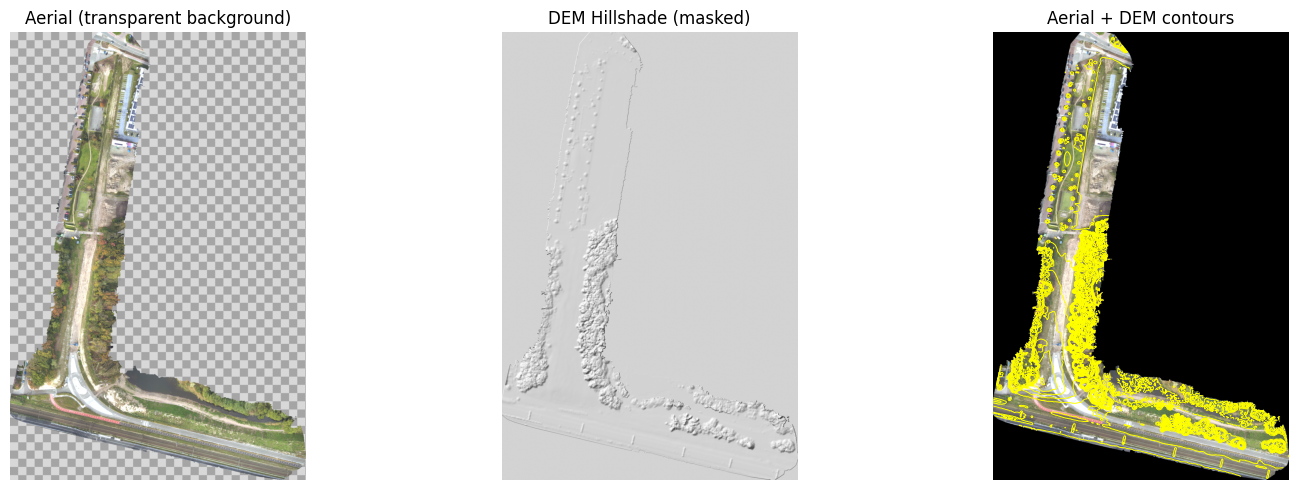

In [ ]:
# Visual check with perfectly matched shapes
AERIAL = "/content/aerial_footprint_cropped.tif"
DEM    = "/content/dem_footprint_cropped.tif"

import numpy as np
import rasterio as rio
from rasterio.enums import Resampling
import matplotlib.pyplot as plt

def norm01(x):
    x = x.astype(np.float32)
    vmin = np.nanpercentile(x, 1); vmax = np.nanpercentile(x, 99)
    return np.clip((x - vmin) / max(vmax - vmin, 1e-6), 0, 1)

def hillshade(elev, azimuth=315, altitude=45, cellsize=1.0):
    gx, gy = np.gradient(elev, cellsize, cellsize)
    slope  = np.pi/2 - np.arctan(np.hypot(gx, gy))
    aspect = np.arctan2(-gx, gy)
    az = np.deg2rad(azimuth); alt = np.deg2rad(altitude)
    hs = (np.sin(alt)*np.sin(slope) + np.cos(alt)*np.cos(slope)*np.cos(az - aspect))
    hs = (hs - np.nanmin(hs)) / max(np.nanmax(hs) - np.nanmin(hs), 1e-9)
    return hs.astype(np.float32)

with rio.open(AERIAL) as a_ds, rio.open(DEM) as d_ds:
    # grid check
    print("Exact grid match:",
          a_ds.crs == d_ds.crs and a_ds.transform == d_ds.transform and
          a_ds.width == d_ds.width and a_ds.height == d_ds.height)

    H, W = a_ds.height, a_ds.width
    max_wh = 1800
    s = max(1, int(np.ceil(max(H, W)/max_wh)))
    out_h, out_w = max(1, H//s), max(1, W//s)

    # --- Read aerial RGB to (out_h, out_w)
    if a_ds.count >= 3:
        rgb = a_ds.read([1,2,3], out_shape=(3, out_h, out_w),
                        resampling=Resampling.bilinear).astype(np.float32)
        rgb = np.moveaxis(rgb, 0, -1)
        for b in range(3): rgb[..., b] = norm01(rgb[..., b])
    else:
        b1 = a_ds.read(1, out_shape=(out_h, out_w), resampling=Resampling.bilinear)
        rgb = np.repeat(norm01(b1)[..., None], 3, axis=-1)

    # --- Read mask to the SAME (out_h, out_w) — IMPORTANT
    a_mask = a_ds.read_masks(1, out_shape=(out_h, out_w),
                             resampling=Resampling.nearest) > 0

    # --- Read DEM to the SAME (out_h, out_w)
    dem = d_ds.read(1, out_shape=(out_h, out_w),
                    resampling=Resampling.bilinear).astype(np.float32)
    dem = np.where(dem == d_ds.nodata, np.nan, dem)
    hs = hillshade(np.nan_to_num(dem, nan=np.nanmin(dem)))
    hs_rgb = np.repeat(hs[..., None], 3, axis=-1)

    print("Shapes:", "rgb", rgb.shape, "| mask", a_mask.shape, "| dem", dem.shape)

    # Checkerboard background
    tile = 32
    rr, cc = np.indices((out_h, out_w))
    checker = ((rr // tile) + (cc // tile)) % 2
    bg = np.where(checker[..., None] == 0, 0.85, 0.65).astype(np.float32)

    comp = np.where(a_mask[..., None], rgb, bg)

    # --- Plots ---
    fig, axs = plt.subplots(1, 3, figsize=(16, 5))
    axs[0].imshow(comp); axs[0].set_title("Aerial (transparent background)"); axs[0].axis('off')
    axs[1].imshow(hs, cmap='gray'); axs[1].set_title("DEM Hillshade (masked)"); axs[1].axis('off')
    axs[2].imshow(rgb);
    axs[2].contour(dem, levels=np.linspace(np.nanpercentile(dem, 2),
                                           np.nanpercentile(dem, 98), 12),
                   linewidths=0.7, colors='yellow')
    axs[2].set_title("Aerial + DEM contours"); axs[2].axis('off')
    plt.tight_layout(); plt.show()
